# Plot SEA-POL sampling at different azimuths

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import json

## Ship location as a function of time

In [ ]:
DSHIP = xr.open_dataset('/Users/awing/Dropbox/ORCESTRA/data/meteor_meteo_dship_20240923.nc')

In [ ]:
#Ship track info
shipLat = DSHIP.lat
shipLon = DSHIP.lon
shipTrackTime = DSHIP.time
shipHeading = DSHIP.ship_heading
#shipHeading = calcshipHeading(shipLon,shipLat)
DSHIP.close()

# Coordinates

In [ ]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 'bcoNorth': 13.15, 'bcoEast': -59.42} 
latitudePirata = [-10,0,15,0,8,0,12,4,0,-6,0,-8,-14,-19,11.5,4,-6,21,20]
longitudePirata = [-10,-10,-38,-35,-38,0,-38,-38,-23,-10,-23,-30,-32,-34,-23,-23,8,-23,-38]

In [ ]:
#planned track

planLON = [-24.98, -23, -23, -23.4, -23.4, -23.8, -32, -32, -32.4, -32.4, -32.8, -47, -47, -47.4, -47.4, -47.4, -59.42]
planLAT = [16.88, 14.5, -0.5, 14.5, 2.5, 7.5, 7.5, 14.5, 2.5, 14.5, 7.5, 7.5, 14.5, 5, 7.9, 14.9, 13.15]

In [ ]:
def calcshipHeading(shipLon,shipLat):
    dlon = np.diff(shipLon)
    shipHeading=np.empty(len(dlon))
    for hh in range(len(dlon)):
        X = np.cos(np.radians(shipLat[hh+1]))*np.sin(np.radians(dlon[hh]))
        Y = np.cos(np.radians(shipLat[hh]))*np.sin(np.radians(shipLat[hh+1]))-np.sin(np.radians(shipLat[hh]))*np.cos(np.radians(shipLat[hh+1]))*np.cos(np.radians(dlon[hh]))
        init_bearing = np.arctan2(X,Y)
        shipHeading[hh] = np.degrees(init_bearing)

    ideg = np.squeeze(np.where(shipHeading<0))
    shipHeading[ideg]=shipHeading[ideg]+360

    return shipHeading

In [ ]:
#Calculate fraction of SEA-POL sampling at each azimuth

#hours in each track leg (hours)
#shipHeadingTime = np.diff(shipTrackTime)/60
#shipHeadingTime=shipHeadingTime.astype("float64")
shipHeadingTime=np.zeros(len(shipTrackTime)-1)+1/60 #1 minutes

#calculate range of azimuths (WRT N) sampled by SEA-POL, assuming bridge blocks 105-210 degrees with respect to shipHeading
azimuths = np.arange(0, 365, 5)
coverage = np.zeros(len(azimuths))

#radar coverage from 0 to 37
seapolstart0 = np.array(shipHeading)
seapolend0 = np.array(shipHeading)+37
ifix0 = np.squeeze(np.where(seapolend0>360))
seapolend0[ifix0]=seapolend0[ifix0]-360

#radar coverage from 45 to 105
seapolstart1 = np.array(shipHeading)+45
seapolend1 = np.array(shipHeading)+105
ifix1 = np.squeeze(np.where(seapolend1>360))
seapolend1[ifix1]=seapolend1[ifix1]-360

##radar coveage from 0 to 105
#seapolstart1 = np.array(shipHeading)
#seapolend1 = np.array(shipHeading)+105
#ifix1 = np.squeeze(np.where(seapolend1>360))
#seapolend1[ifix1]=seapolend1[ifix1]-360

#radar coverage from 210 to 360
seapolstart2 = np.array(shipHeading)-150 
seapolend2 = np.array(shipHeading)
ifix2 = np.squeeze(np.where(seapolstart2<0))
seapolstart2[ifix2]=seapolstart2[ifix2]+360

#loop over each track leg, summing up time SEA-POL sees each range of azimuths
for ht in range(len(shipHeadingTime)):

    #0 to 37 
    i0=np.squeeze(np.where(np.absolute(azimuths-seapolstart0[ht])==np.min(np.absolute(azimuths-seapolstart0[ht]))))
    i1=np.squeeze(np.where(np.absolute(azimuths-seapolend0[ht])==np.min(np.absolute(azimuths-seapolend0[ht]))))
    if i0<i1:
        coverage[i0:i1+1]=coverage[i0:i1+1]+shipHeadingTime[ht]
    else: #goes around 0
        coverage[i0:len(coverage)+1] = coverage[i0:len(coverage)+1]+shipHeadingTime[ht] #go from azimuths(i0) to 360deg
        coverage[0:i1+1] = coverage[0:i1+1]+shipHeadingTime[ht] #go from 0deg to azimuths(i1)

    #43 to 105
    i2=np.squeeze(np.where(np.absolute(azimuths-seapolstart1[ht])==np.min(np.absolute(azimuths-seapolstart1[ht]))))
    i3=np.squeeze(np.where(np.absolute(azimuths-seapolend1[ht])==np.min(np.absolute(azimuths-seapolend1[ht]))))
    if i2<i3:
        coverage[i2:i3+1]=coverage[i2:i3+1]+shipHeadingTime[ht]
    else: #goes around 0
        coverage[i2:len(coverage)+1] = coverage[i2:len(coverage)+1]+shipHeadingTime[ht] #go from azimuths(i2) to 360deg
        coverage[0:i3+1] = coverage[0:i3+1]+shipHeadingTime[ht] #go from 0deg to azimuths(i3)

    #210 to 360
    i4=np.squeeze(np.where(np.absolute(azimuths-seapolstart2[ht])==np.min(np.absolute(azimuths-seapolstart2[ht]))))
    i5=np.squeeze(np.where(np.absolute(azimuths-seapolend2[ht])==np.min(np.absolute(azimuths-seapolend2[ht]))))
    if i4<i5:
        coverage[i4:i5] = coverage[i4:i5]+shipHeadingTime[ht] #don't count shipHeading again
    else: #goes around 0
        coverage[i4:len(coverage)+1] = coverage[i4:len(coverage)+1]+shipHeadingTime[ht] #go from azimuths(i4) to 360deg
        coverage[0:i5] = coverage[0:i5]+shipHeadingTime[ht] #go from 0deg to azimuths(i5), don't count shipHeading again


######
#    i1=np.squeeze(np.where(np.absolute(azimuths-seapolstart1[ht])==np.min(np.absolute(azimuths-seapolstart1[ht]))))
#    i2=np.squeeze(np.where(np.absolute(azimuths-seapolend1[ht])==np.min(np.absolute(azimuths-seapolend1[ht]))))
#    if i1<i2:
#        coverage[i1:i2+1]=coverage[i1:i2+1]+shipHeadingTime[ht]
#    else: #goes around 0
#        coverage[i1:len(coverage)+1] = coverage[i1:len(coverage)+1]+shipHeadingTime[ht] #go from azimuths(i1) to 360deg
#        coverage[0:i2+1] = coverage[0:i2+1]+shipHeadingTime[ht] #go from 0deg to azimuths(i2)
#
#    i3=np.squeeze(np.where(np.absolute(azimuths-seapolstart2[ht])==np.min(np.absolute(azimuths-seapolstart2[ht]))))
#    i4=np.squeeze(np.where(np.absolute(azimuths-seapolend2[ht])==np.min(np.absolute(azimuths-seapolend2[ht]))))
#    if i3<i4:
#        coverage[i3:i4] = coverage[i3:i4]+shipHeadingTime[ht] #don't count shipHeading again
#    else: #goes around 0
#        coverage[i3:len(coverage)+1] = coverage[i3:len(coverage)+1]+shipHeadingTime[ht] #go from azimuths(i3) to 360deg
#        coverage[0:i4] = coverage[0:i4]+shipHeadingTime[ht] #go from 0deg to azimuths(i4), don't count shipHeading again
coverage

Text(0.5, 1.0, 'SEA-POL Sampling')

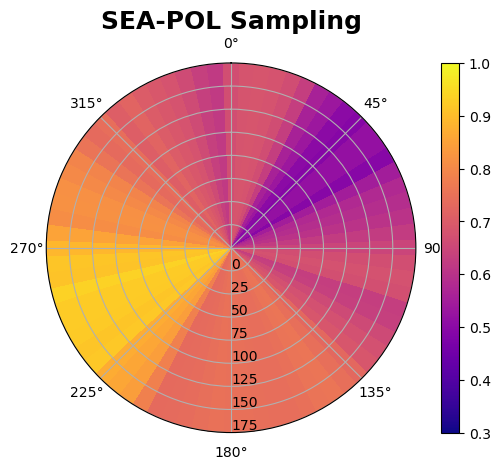

In [ ]:
# Plot the SEA-POL coverage
radius = np.arange(0,151,50)
hoursTOT = np.sum(shipHeadingTime)
coverage2 = np.tile(coverage,(len(radius),1))

#polar plot
fig = plt.figure()
ax = fig.add_subplot(111,polar=True)
h1 = ax.pcolormesh(np.radians(azimuths),radius,coverage2/hoursTOT,cmap='plasma',vmin=0.3,vmax=1.0)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(180)
fig.colorbar(h1)
ax.set_title('SEA-POL Sampling',fontsize=18, weight='bold', loc='center')

#plt.savefig('./figures/seapolsampling-percent.png')